# Flux calibration

Photometric and spectroscopic measurements of directly imaged planets typically provide the flux contrast between the companion and star. To calibrate the contrast of the companion to a flux or apparent magnitude requires an absolute measurement of the stellar flux.

In this tutorial, we will we will fit the [2MASS](https://irsa.ipac.caltech.edu/Missions/2mass.html) magnitudes of the G7 type star [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel) with the [BT-NextGen](http://svo2.cab.inta-csic.es/svo/theory/newov2/index.php?models=bt-nextgen-agss2009) model spectra. From the posterior samples, we will then compute synthetic photometry for the [VLT/ERIS M' filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/ERIS.Mp&&mode=browse&gname=Paranal&gname2=ERIS#filter) and a synthetic spectrum for a given instrument resolution and wavelength binning.

## Getting started

We start by importing the required Python modules.

In [1]:
import numpy as np
import species

Next, we initiate the workflow by calling the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit) class. This will create both the [HDF5 database](https://species.readthedocs.io/en/latest/database.html) and the [configuration file](https://species.readthedocs.io/en/latest/configuration.html) in the working folder.

In [2]:
species.SpeciesInit()

Initiating species v0.5.3... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Grid interpolation method: linear
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


We then create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which provides read and write access to the HDF5 database.

In [3]:
database = species.Database()

We also create a tuple with the [Gaia EDR3](http://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G) parallax of [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel).

In [4]:
parallax = (21.1621, 0.0223)  # (mas)

And a dictionary with the [2MASS](https://irsa.ipac.caltech.edu/Missions/2mass.html) magnitudes.

In [5]:
magnitudes = {'2MASS/2MASS.J': (6.856, 0.021),
              '2MASS/2MASS.H': (6.486, 0.049),
              '2MASS/2MASS.Ks': (6.366, 0.024)}

We also create a list of the filter names for use later on.

In [6]:
filters = list(magnitudes.keys())

## Adding stellar photometry

We can now store the parallax and magnitudes of PZ Tel in the database by using the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. This will also download a flux-calibrated spectrum of Vega and convert the magnitudes into fluxes.

In [7]:
database.add_object(object_name='PZ Tel',
                    parallax=parallax,
                    app_mag=magnitudes,
                    spectrum=None)

Adding filter: 2MASS/2MASS.J... [DONE]
Adding filter: 2MASS/2MASS.H... [DONE]
Adding filter: 2MASS/2MASS.Ks... [DONE]
Adding Vega spectrum... [DONE]
Adding object: PZ Tel
   - Parallax (mas) = 21.16 +/- 0.02
   - 2MASS/2MASS.J:
      - Apparent magnitude = 6.86 +/- 0.02
      - Flux (W m-2 um-1) = 5.81e-12 +/- 1.12e-13
   - 2MASS/2MASS.H:
      - Apparent magnitude = 6.49 +/- 0.05
      - Flux (W m-2 um-1) = 2.98e-12 +/- 1.34e-13
   - 2MASS/2MASS.Ks:
      - Apparent magnitude = 6.37 +/- 0.02
      - Flux (W m-2 um-1) = 1.25e-12 +/- 2.76e-14


## Adding a grid of model spectra

Next, we will download the *BT-NextGen* grid and add the spectra of a limited $T_\mathrm{eff}$ range to the database.

In [8]:
database.add_model('bt-nextgen', teff_range=(4500., 5500.))

Unpacking BT-NextGen model spectra (368 MB)... [DONE]
Wavelength range (um) = 0.1 - 50
Spectral resolution = 4000
Teff range (K) = 4500.0 - 5500.0
Adding BT-NextGen model spectra... [DONE]                                        
Grid points stored in the database:
   - Teff = [4500. 4600. 4700. 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500.]
   - log(g) = [3. 4. 5.]
   - [Fe/H] = [0.  0.3 0.5]


## Fitting the 2MASS fluxes with the calibration spectrum

Now that we have prepared the database, we can fit the photometric fluxes with the model grid. To do so, we use the [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel) class, which provides a Bayesian framework for parameter estimation. The argument of `bounds` contains a dictionary with the priors that are used. In this example, we fix $T_\mathrm{eff}$, $\log(g)$, and $[\mathrm{Fe}/\mathrm{H}]$, so we effectively scale the model spectrum to the data by adjusting the distance and radius. We will also account for a instrument-specific error inflation, relative to the actual uncertainties on the 2MASS fluxes. Finally, the parallax is automatically included with a Gaussian prior.

In [9]:
fit = species.FitModel(object_name='PZ Tel',
                       model='bt-nextgen',
                       bounds={'teff': (5000., 5000.),
                               'logg': (4., 4.),
                               'feh': (0., 0.),
                               'radius': (1., 20.),
                               '2MASS/2MASS_error': (0., 1.)},
                       inc_phot=True,
                       inc_spec=False)

Getting object: PZ Tel... [DONE]
Interpolating 2MASS/2MASS.H... [DONE]
Interpolating 2MASS/2MASS.J... [DONE]
Interpolating 2MASS/2MASS.Ks... [DONE]
Fixing 3 parameters:
   - teff = 5000.0
   - logg = 4.0
   - feh = 0.0
Fitting 3 parameters:
   - radius
   - parallax
   - 2MASS/2MASS_error
Prior boundaries:
   - radius = (1.0, 20.0)
   - 2MASS/2MASS_error = (0.0, 1.0)
Weights for the log-likelihood function:
   - 2MASS/2MASS.H = 1.00e+00
   - 2MASS/2MASS.J = 1.00e+00
   - 2MASS/2MASS.Ks = 1.00e+00


We will sample the posterior distribution with the [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest), which uses the nested sampling implementation of [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html). The samples will be stored in the database by the `tag` name. Let's run the sampler with 500 live points!

In [10]:
fit.run_ultranest(tag='pztel',
                  min_num_live_points=500,
                  output='ultranest/',
                  prior=None)

Running nested sampling with UltraNest...
Creating directory for new run ultranest/run1
[ultranest] Sampling 500 live points from prior ...


/Users/tomasstolker/.pyenv/versions/3.10.0/envs/species3.10/lib/python3.10/site-packages/ultranest/store.py:195: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'points', dtype=np.float,


[ultranest] Explored until L=8e+01  84.4572..84.4572]*| it/evals=5040/9069 eff=58.8167% N=500 
[ultranest] Likelihood function evaluations: 9078
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 78.97 +- 0.05681
[ultranest] Effective samples strategy satisfied (ESS = 3494.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.
Log-evidence = 78.98 +/- 0.09
Best-fit parameters (mean +/- std):
   - radius = 1.22e+01 +/- 1.09e+00
   - parallax = 2.12e+01 +/- 2.24e-02
   - 2MASS/2MASS_error = 1.79e-01 +/- 1.82e-01
Maximum likelihood sample:
   - Log-likelihood = 84.48
   - radius = 12.40
   - parallax = 21.16
   - 2MASS/2MASS_error = 0.04
Integrated autocorrelation ti

/Users/tomasstolker/.pyenv/versions/3.10.0/envs/species3.10/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


## Plotting the posterior distribution

After running the sampler, we can plot the posterior distribution of the 3 free parameters with the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) by simply pointing to the database `tag` that was specified with [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest).

Median sample:
   - radius = 1.24e+01
   - parallax = 2.12e+01
   - 2MASS/2MASS_error = 1.10e-01
   - teff = 5.00e+03
   - logg = 4.00e+00
   - feh = 0.00e+00
Plotting the posterior...

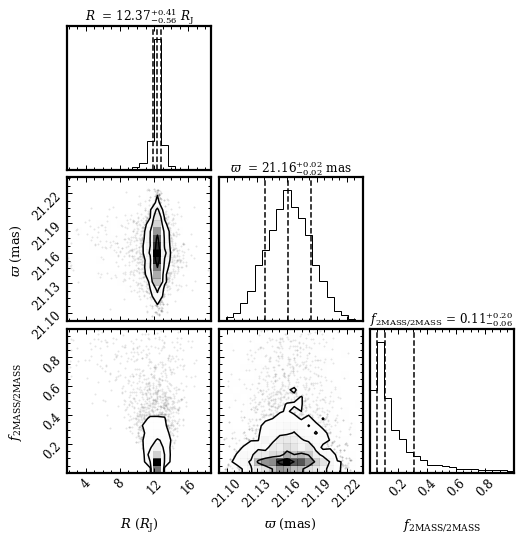

 [DONE]


In [11]:
species.plot_posterior(tag='pztel',
                       offset=(-0.3, -0.3),
                       output=None)

## Extracting spectral samples

Later on, we will create a plot of the data, best-fit spectrum, and random spectral samples of the posterior distribution. We start by drawing 30 random samples the posterior distribution and calculate spectra at $R = 500$. The [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) returns a list with [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) objects.

In [12]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=30,
                                    wavel_range=(0.5, 10.),
                                    spec_res=500.)

Getting MCMC spectra:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/tomasstolker/applications/species/species/read/read_model.py:710: UserWarning: The '2MASS/2MASS_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


Let's have a look at the content of the first [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) by using the [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method.

In [13]:
samples[0].open_box()

Opening ModelBox...
model = bt-nextgen
type = None
wavelength = [ 0.49989727  0.50002105  0.50014486 ...  9.99710369  9.99957902
 10.00205496]
flux = [1.37184231e-11 1.34779365e-11 1.32301197e-11 ... 3.59218586e-15
 3.58986194e-15 3.58794421e-15]
parameters = {'radius': 12.420308338019463, 'parallax': 21.182051583945388, '2MASS/2MASS_error': 0.018544943790753728, 'teff': 5000.0, 'logg': 4.0, 'feh': 0.0, 'luminosity': 0.917295656810917, 'mass': 622.3707986105776}
quantity = flux
contribution = None
bol_flux = None


Next, we extract the best-fit parameters from the posterior distribution, for which we adopt the median values. The [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_median_sample) return a dictionary with the parameters, including the ones that were fixed with [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel).

In [14]:
median = database.get_median_sample(tag='pztel')
print(median)

{'radius': 12.366038264558238, 'parallax': 21.16180505102594, '2MASS/2MASS_error': 0.10982890648877373, 'teff': 5000.0, 'logg': 4.0, 'feh': 0.0}


Next, we interpolate the the *BT-NextGen* grid at the best-fit parameters. To do so, we first create an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) and then use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method to interpolate the grid with the median parameters that are provided to `model_par`.  Similar to [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra), we also smooth this spectrum to $R = 500$. The model spectrum is again returned in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [15]:
read_model = species.ReadModel(model='bt-nextgen', wavel_range=(0.2, 30.))
model_box = read_model.get_model(model_param=median, spec_res=500., smooth=True)

Each [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) is a *Python* object so the content is easily accessed as attributes.

In [16]:
print(model_box.parameters)

{'radius': 12.366038264558238, 'parallax': 21.16180505102594, '2MASS/2MASS_error': 0.10982890648877373, 'teff': 5000.0, 'logg': 4.0, 'feh': 0.0, 'luminosity': 0.909296991772413, 'mass': 616.9438291151159}


## Extracting the object data

For the plot, we also require the data of PZ Tel. These can be extracted with the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object), which returns the data (e.g. photometry, spectra, and parallax) for a given `object_name`.

In [17]:
object_box = database.get_object(object_name='PZ Tel')

Getting object: PZ Tel... [DONE]


The data are stored in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). Let's have a look at the content by using [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box).

In [18]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684}
magnitude = {'2MASS/2MASS.H': array([6.486, 0.049]), '2MASS/2MASS.J': array([6.856, 0.021]), '2MASS/2MASS.Ks': array([6.366, 0.024])}
flux = {'2MASS/2MASS.H': array([2.97565316e-12, 1.34338807e-13]), '2MASS/2MASS.J': array([5.81192273e-12, 1.12419561e-13]), '2MASS/2MASS.Ks': array([1.25057897e-12, 2.76460704e-14])}
spectrum = None
parallax = [21.1621  0.0223]
distance = None


With [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel) it is possible to account for systematic errors with the data calibration, for example to scale individual spectra or inflate the uncertainties. Since we inflated the 2MASS uncertainties during the fit, we will use the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_objectbox) function to adjust the photometric precision with the best-fit error inflation as extracted with [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_median_sample).

In [19]:
object_box = species.update_objectbox(object_box, median)

Inflating the error of 2MASS/2MASS.H (W m-2 um-1): 3.27e-13... [DONE]
Inflating the error of 2MASS/2MASS.J (W m-2 um-1): 6.38e-13... [DONE]
Inflating the error of 2MASS/2MASS.Ks (W m-2 um-1): 1.37e-13... [DONE]


## Residuals and synthetic photometry

Before creating the plot, there are two more boxes that we will create. First, we use the [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.get_residuals) function to calculate the residuals (i.e. data minus model, relative to the data uncertainties), together with the reduced $\chi^2$. The residuals and mean wavelengths are stored in a [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) for each of the 2MASS filters.

In [20]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='bt-nextgen',
                                  parameters=median,
                                  objectbox=object_box,
                                  inc_phot=True,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - 2MASS/2MASS.H: -0.52
   - 2MASS/2MASS.J: 0.58
   - 2MASS/2MASS.Ks: -0.09
Reduced chi2 = -0.21
Number of degrees of freedom = -3


In [21]:
residuals.open_box()

Opening ResidualsBox...
name = PZ Tel
photometry = {'2MASS/2MASS.H': array([ 1.65136646, -0.52243649]), '2MASS/2MASS.J': array([1.24105171, 0.57996391]), '2MASS/2MASS.Ks': array([ 2.16563112, -0.08833422])}
spectrum = None
chi2_red = -0.2057003186354537


Secondly, we will also use the dictionary with best-fit parameters to calculate synthetic photometry for the three filters that were used in the fit. The [multi_photometry](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.multi_photometry) returns a [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox), which includes a dictionary with the photometric fluxes.

In [22]:
syn_phot = species.multi_photometry(datatype='model',
                                    spectrum='bt-nextgen',
                                    filters=filters,
                                    parameters=median)

Calculating synthetic photometry... [DONE]


In [23]:
syn_phot.open_box()

Opening SynphotBox...
name = synphot
flux = {'2MASS/2MASS.J': 5.436024277627977e-12, '2MASS/2MASS.H': 3.1602540695429965e-12, '2MASS/2MASS.Ks': 1.2629549826137048e-12}


## Plotting the data and model spectra

We have now prepared all the boxes with data so we are ready to combine them in a plot of the spectral energy distribution (SED) of PZ Tel! The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function requires a list of [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects as argument of boxes. For each box we can set the plot style, by providing a list with dictionaries as argument of `plot_kwargs`, in the same order as the list of boxes. Items in the list can be set to `None`, in which case some default values are used. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is passed as argument of `residuals` and will also plot the filter profiles by providing the list with names as argument to `filters`. Finally, there is a handful of parameters that can be adjusted for the appearance of the plot (see the API documentation of [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) for details). Let's have a look at the plot!

Plotting spectrum...

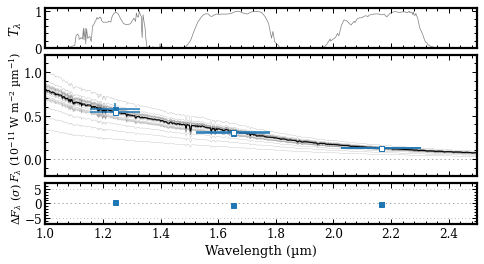

 [DONE]


In [24]:
species.plot_spectrum(boxes=[samples, model_box, object_box, syn_phot],
                      filters=filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                   {'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'2MASS/2MASS.J': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    '2MASS/2MASS.H': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    '2MASS/2MASS.Ks': {'marker': 's', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'}},
                                   None],
                      xlim=(1., 2.5),
                      ylim=(-2e-12, 1.2e-11),
                      ylim_res=(-7., 7.),
                      scale=('linear', 'linear'),
                      offset=(-0.5, -0.05),
                      figsize=(6., 3.),
                      output=None)

## Photometric calibration

Now that we have the posterior samples of the atmospheric parameters, we can calculated synthetic photometry (including uncertainties) for any other filter. As an example, we will calculate the magnitude and flux for the VLT/ERIS $M'$ filter. The [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior) function plots the distribution of the magnitudes, by propagating the posterior of the atmospheric parameters, and returns an array with the samples. We simply need to specify the database `tag` and provide the `filter_name` name as listed on the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)).

Adding filter: Paranal/ERIS.Mp... [DONE]


Getting MCMC photometry:   0%|          | 0/5546 [00:00<?, ?it/s]

Plotting photometry samples...

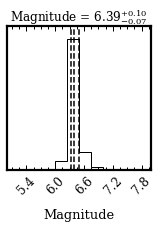

 [DONE]


In [25]:
phot_mag = species.plot_mag_posterior(tag='pztel',
                                      filter_name='Paranal/ERIS.Mp',
                                      xlim=(5., 8.),
                                      output=None)

There is also the [get_mcmc_photometry](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_photometry) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which works in a similar way as [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior), but can also return the posterior of the flux density instead of the magnitude.

In [26]:
phot_flux = database.get_mcmc_photometry(tag='pztel',
                                         filter_name='Paranal/ERIS.Mp',
                                         phot_type='flux')

Getting MCMC photometry:   0%|          | 0/5546 [00:00<?, ?it/s]

To calculate the flux density in the $M'$-band, we simply adopt the mean and the standard deviation of the distribution.

In [27]:
print(f'Flux density (W m-2 um-1) = {np.mean(phot_flux):.2e} +/- {np.std(phot_flux):.2e}')

Flux density (W m-2 um-1) = 5.91e-14 +/- 9.09e-15


## Spectral calibration

We can also compute a stellar, synthetic spectrum with uncertainties for a specific instrument. To do so, we use again the [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method from earlier, but this time we draw a larger number of spectra. Furthermore, for our hypothetical instrument, we assume a resolving power of $R = 100$ and set the wavelength points (20 linearly-spaced points between 1 and 2.5 $\mu$m) as argument of `wavel_resample`.

In [28]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=100,
                                    wavel_range=(0.5, 10.),
                                    spec_res=100.,
                                    wavel_resample=np.linspace(1., 2.5, 20))

Getting MCMC spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Next, we calculate the mean and standard deviation of the 100 samples, which we adopt as the synthetic spectrum of PZ Tel.

In [29]:
spec_flux = np.mean([box.flux for box in samples], axis=0)
spec_sigma = np.std([box.flux for box in samples], axis=0)

Let's write the synthetic spectrum to a text file. 

In [30]:
calib_spec = np.column_stack([samples[0].wavelength, spec_flux, spec_sigma])
np.savetxt('calib_spec.dat', calib_spec)

Now we can use the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method to append the spectrum to the data of PZ Tel in the database. The parallax and magnitudes were already provided previously so we can set the arguments of `parallax` and `app_mag` to `None`.

In [31]:
database.add_object(object_name='PZ Tel',
                    parallax=None,
                    app_mag=None,
                    spectrum={'calibration': ('calib_spec.dat', None, 100.)})

Adding object: PZ Tel
   - Spectrum:
      - Database tag: calibration
      - Filename: calib_spec.dat
      - Data shape: (20, 3)
      - Wavelength range (um): 1.00 - 2.50
      - Mean flux (W m-2 um-1): 3.11e-12
      - Mean error (W m-2 um-1): 4.62e-13
   - Spectral resolution:
      - calibration: 100.0


Next, we use the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object) method for extracting all the data of PZ Tel from the database and storing these in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). We need to apply again the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_objectbox) function to account for the inflated errors of the 2MASS fluxes.

In [32]:
object_box = database.get_object(object_name='PZ Tel')
object_box = species.update_objectbox(object_box, median)

Getting object: PZ Tel... [DONE]
Inflating the error of 2MASS/2MASS.H (W m-2 um-1): 3.27e-13... [DONE]
Inflating the error of 2MASS/2MASS.J (W m-2 um-1): 6.38e-13... [DONE]
Inflating the error of 2MASS/2MASS.Ks (W m-2 um-1): 1.37e-13... [DONE]


If we now open the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) with [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) then we see that the synthetic spectrum is indeed included together with the previously added data.

In [33]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684}
magnitude = {'2MASS/2MASS.H': array([6.486, 0.049]), '2MASS/2MASS.J': array([6.856, 0.021]), '2MASS/2MASS.Ks': array([6.366, 0.024])}
flux = {'2MASS/2MASS.H': array([2.97565316e-12, 3.53346116e-13]), '2MASS/2MASS.J': array([5.81192273e-12, 6.48141112e-13]), '2MASS/2MASS.Ks': array([1.25057897e-12, 1.40104429e-13])}
spectrum = {'calibration': (array([[1.00000000e+00, 7.81304800e-12, 1.15854358e-12],
       [1.07894737e+00, 6.76254628e-12, 1.00277184e-12],
       [1.15789474e+00, 5.95775641e-12, 8.83435044e-13],
       [1.23684211e+00, 5.33967107e-12, 7.91783388e-13],
       [1.31578947e+00, 4.81784317e-12, 7.14405089e-13],
       [1.39473684e+00, 4.35889708e-12, 6.46351105e-13],
       [1.47368421e+00, 3.87326887e-12, 5.74340612e-13],
       [1.55263158e+00, 3.57743620

Let's have a look at the content of the returned [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) by simply passing it to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function!

Plotting spectrum...

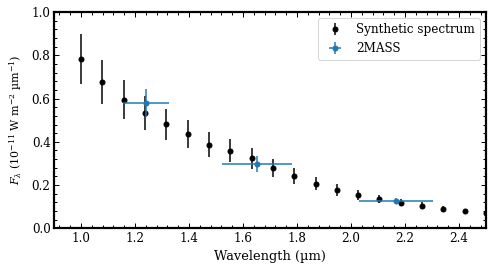

 [DONE]


In [34]:
species.plot_spectrum(boxes=[object_box],
                      plot_kwargs=[{'calibration': {'marker': 'o', 'ms': 5., 'color': 'black', 'ls': 'none', 'label': 'Synthetic spectrum'},
                                    '2MASS/2MASS.J': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none', 'label': '2MASS'},
                                    '2MASS/2MASS.H': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                    '2MASS/2MASS.Ks': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'}}],
                      xlim=(0.9, 2.5),
                      ylim=(0., 1e-11),
                      scale=('linear', 'linear'),
                      offset=(-0.1, -0.07),
                      figsize=(6., 3.),
                      legend={'loc': 'upper right', 'fontsize': 12.},
                      output=None)